<table class="ee-notebook-buttons" align="center">
    <td><a target="_blank"  href="https://colab.research.google.com/github/ytarazona/scikit-eo/blob/main/examples/14_Deep_Learning_Classification_FullyConnected.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
</table>

# **_<div class="alert alert-success"><font color='darkred'> Tutorials: 14 Deep Learning Classification</font></div>_**

# 1.0 Libraries

To install ```scikit-eo``` and ```rasterio``` you can do it with the following line:

In [ ]:
!pip install scikeo rasterio dbfread

Libraries to be used:

In [ ]:
import rasterio
import numpy as np
from scikeo.deeplearning import DL
from scikeo.process import extract
import matplotlib.pyplot as plt
from dbfread import DBF
import matplotlib as mpl
import pandas as pd

Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 2.0 Optical image

Landsat-8 OLI (Operational Land Imager) will be used to obtain in order to classify using Deep Learning. This image, which is in surface reflectance with bands:
- Blue -> B2
- Green -> B3
- Red -> B4
- Nir -> B5
- Swir1 -> B6
- Swir2 -> B7

The image and signatures to be used can be downloaded [here](https://drive.google.com/drive/folders/12B35BI54GgRtRCyu7RhI06j-vmrrljiy?usp=sharing):

In [ ]:
path_raster = r"F:\RepositoriosGitHub\scikit-eo-tutorials\data\11_deepLearning\LC08_232066_20190727_SR.tif"
img = rasterio.open(path_raster)

path_endm = r"F:\RepositoriosGitHub\scikit-eo-tutorials\data\11_deepLearning\endmembers.dbf"
endm = DBF(path_endm)

In [ ]:
# endmembers
endm = extract(img, endm)
endm

,class,b1_LC08_23,b2_LC08_23,b3_LC08_23,b4_LC08_23,b5_LC08_23,b6_LC08_23
0,0.0,646,1137,1446,569,53,33
1,0.0,658,1141,1449,585,68,44
2,0.0,663,1149,1455,573,67,43
3,0.0,657,1147,1453,556,48,29
4,0.0,662,1147,1451,557,52,31


Instance of ```DL()```:

In [ ]:
inst = DL(image = img, endmembers = endm)

Applying the ```FullyConnected()``` function of Deep Learning:

- *Number of hidden layers to be used*: 4
- *Number of units to be used*. This is related to 'neurons' in each hidden layers [64,16,8,8]
- *Number of clases to be obtained*: output_units is 4 (four classes)
- *Input_shape*: The input shape is generally the shape of the input data provided to the Keras model while training
- *Epochs*: Number of iterations iqual 100
- *Batch_size*: 32
- *Training_split*: 80%

In [ ]:
fc = inst.FullyConnected(hidden_layers = 4,
                         hidden_units = [64,16,8,8],
                         output_units = 4,
                         input_shape = (6,),
                         epochs = 100,
                         batch_size = 32,
                         training_split = 0.8)

## 3.0 Results

Dictionary of results

In [ ]:
fc.keys()

dict_keys(['Overall_Accuracy', 'Kappa_Index', 'Confusion_Matrix', 'Classification_Map', 'Image'])

Overall Accuracy

In [ ]:
fc.get('Overall_Accuracy')

0.9375

Kappa index

In [ ]:
fc.get('Kappa_Index')

0.7480314960629921

Confusion matrix or error matrix

In [ ]:
fc.get('Confusion_Matrix')

,0,1,2,3,Total,Users_Accuracy,Commission
0,11.0,0.0,0.0,0.0,11.0,100.000000,0.000000
1,0.0,19.0,0.0,4.0,23.0,82.608696,17.391304
2,0.0,0.0,9.0,0.0,9.0,100.000000,0.000000
3,0.0,0.0,0.0,21.0,21.0,100.000000,0.000000
Total,11.0,19.0,9.0,25.0,NaN,NaN,NaN
Producer_Accuracy,100.0,100.0,100.0,84.0,NaN,NaN,NaN
Omission,0.0,0.0,0.0,16.0,NaN,NaN,NaN


Preparing the image before plotting

In [ ]:
# convert to array
arr_img = img.read()
# stacking the image
rgb = np.stack([arr_img[4,:,:], arr_img[3,:,:], arr_img[2,:,:]], axis = -1)

# Normalizing bands
def stretch_std(arr, std_val):
    """ Returns the data with a standard deviation contrast applied """
    mean = np.mean(arr)
    std = np.std(arr)*std_val
    min_val = np.max([mean - std, np.min(arr)])
    max_val = np.min([mean + std, np.max(arr)])
    clipped_arr = np.clip(arr, min_val, max_val)
    img = (clipped_arr - min_val)/(max_val - min_val)
    return img

rgb_norm = stretch_std(rgb, 2.5)

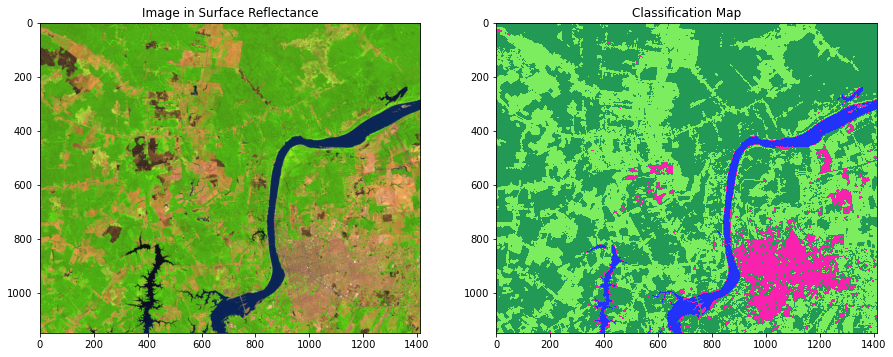

In [ ]:
# Let's define the color palette
palette = mpl.colors.ListedColormap(["#2232F9","#F922AE","#229954","#7CED5E"])

# Let´s plot
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 9))
axes[0].imshow(rgb_norm)
axes[0].set_title("Image in Surface Reflectance")
axes[0].grid(False)

axes[1].imshow(fc.get('Classification_Map'), cmap= palette)
axes[1].set_title("Classification Map")
axes[1].grid(False)